In [20]:
import os
%load_ext autoreload
%autoreload 2
from src.model.one_class import DeepSVDD
from src.trainer.ids import DeepSVDDIDSTrainer, plot_metrics
from src.datamanager.dataset import IDS2017Dataset, ArrhythmiaDataset, ThyroidDataset
from src.trainer.ids import DAGMMIDSTrainer
from src.model.reconstruction import DAGMM
from src.trainer.ids import MemAEIDSTrainer
from src.model.reconstruction import MemAutoEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [21]:
# Setup base folder structure
dataset_path = "../../data/Arrhythmia/arrhythmia.npy"
assert os.path.exists(dataset_path), "unknown path {}".format(dataset_path)

# Checkpoints
dsvdd_ckpt = "deepsvdd/checkpoint"
dagmm_ckpt = "dagmm/checkpoint"
memae_ckpt = "memae/checkpoint"

for path in [dsvdd_ckpt, dagmm_ckpt, memae_ckpt]:
    a, b = path.split("/")
    if not os.path.exists(a):
        os.mkdir(a)
        os.mkdir(os.path.join(a, b))

# General arguments
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 200

# Dataset-specific arguments
dataset_args = {
    "Arrhythmia": {
        "batch_size": 16,
        "dataset_path": "../../data/Arrhythmia/arrhythmia.mat",
        "cls": ArrhythmiaDataset
    },
    "Thyroid": {
        "batch_size": 64,
        "dataset_path": "../../data/Thyroid/thyroid.mat",
        "cls": ThyroidDataset
    },
    "IDS2017": {
        "batch_size": 1024,
        "dataset_path": "../../data/IDS2017/ids2017.csv",
        "cls": IDS2017Dataset
    },
}

# DAGMM-specific arguments
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6
dagmm_best_epoch = 11

# MemAE-specific arguments
mem_dim = 50
shrink_thres = 0.0025
alpha = 2e-4

print("arguments set")

arguments set


## Training

100%|██████████| 13/13 [00:00<00:00, 584.78it/s, epoch=6, loss=1.056]

Training DeepSVDD on Arrhythmia for 200 epochs
Initializing center c...
Center c initialized.
Started training



100%|██████████| 13/13 [00:00<00:00, 609.48it/s, epoch=200, loss=0.001]


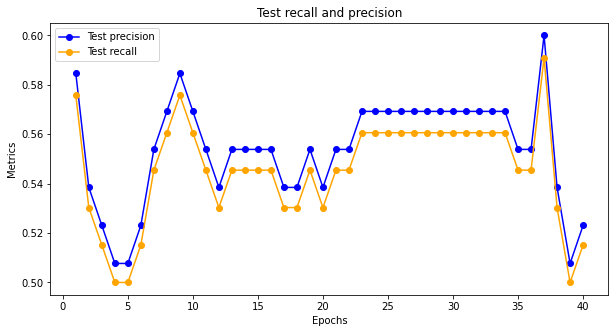

  0%|          | 0/13 [00:00<?, ?it/s]

Training DAGMM on Arrhythmia for 200 epochs
Training DAGMM on Arrhythmia for 200 epochs
Started training


100%|██████████| 13/13 [00:00<00:00, 223.21it/s, epoch=200, loss=6073.794]


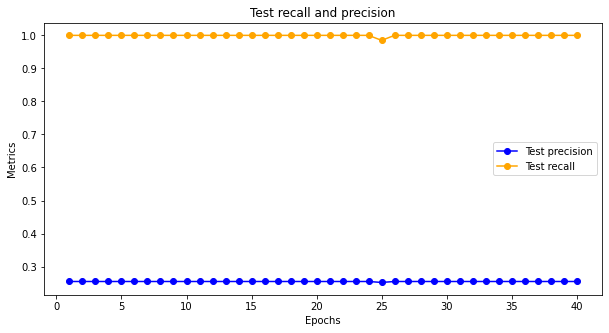

 23%|██▎       | 3/13 [00:00<00:00, 333.08it/s, epoch=6, loss=813.107]

Training MemAE on Arrhythmia for 200 epochs
Started training


100%|██████████| 13/13 [00:00<00:00, 412.54it/s, epoch=200, loss=7.030]


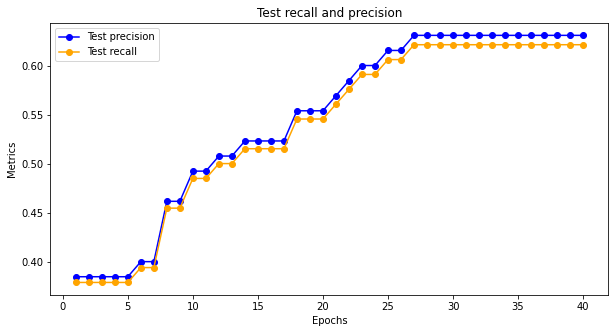

 17%|█▋        | 5/29 [00:00<00:00, 464.84it/s, epoch=5, loss=0.000]

Training DeepSVDD on Thyroid for 200 epochs
Initializing center c...
Center c initialized.
Started training


100%|██████████| 29/29 [00:00<00:00, 776.71it/s, epoch=200, loss=0.000]


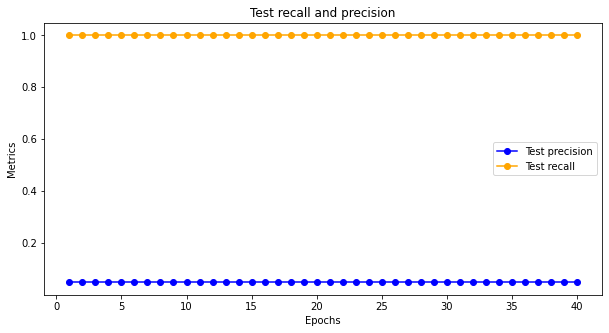

 21%|██        | 6/29 [00:00<00:00, 184.19it/s, epoch=2, loss=2358.642]

Training DAGMM on Thyroid for 200 epochs
Training DAGMM on Thyroid for 200 epochs
Started training


100%|██████████| 29/29 [00:00<00:00, 246.80it/s, epoch=200, loss=4.844]


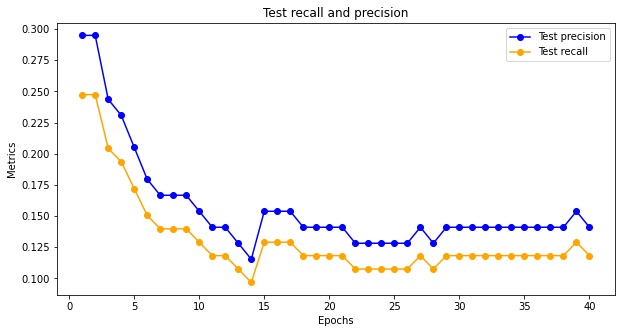

  7%|▋         | 2/29 [00:00<00:00, 232.16it/s, epoch=4, loss=0.191]

Training MemAE on Thyroid for 200 epochs
Started training


100%|██████████| 29/29 [00:00<00:00, 320.79it/s, epoch=200, loss=0.002]


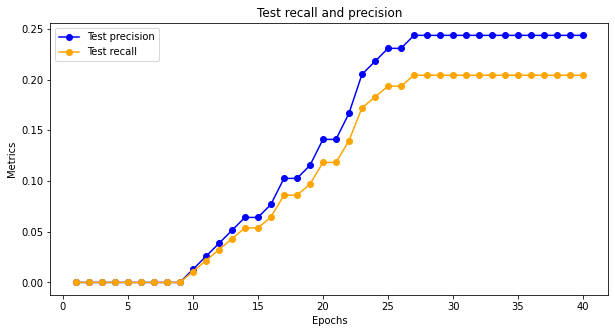

Training DeepSVDD on IDS2017 for 200 epochs
Initializing center c...


  4%|▍         | 44/1110 [00:00<00:04, 222.06it/s, epoch=1, loss=0.001]

Center c initialized.
Started training


100%|██████████| 1110/1110 [00:05<00:00, 214.31it/s, epoch=200, loss=0.000]


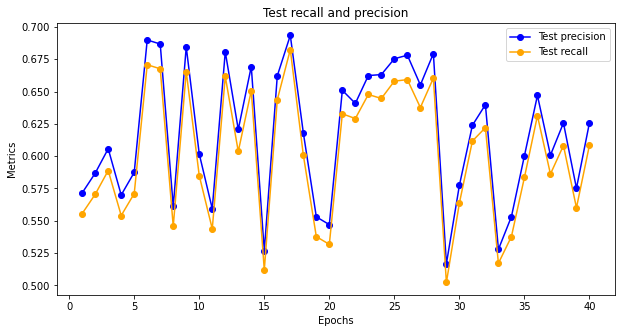

  2%|▏         | 24/1110 [00:00<00:08, 125.10it/s, epoch=1, loss=778835.885]

Training DAGMM on IDS2017 for 200 epochs
Training DAGMM on IDS2017 for 200 epochs
Started training


100%|██████████| 1110/1110 [00:08<00:00, 125.72it/s, epoch=200, loss=2.735]


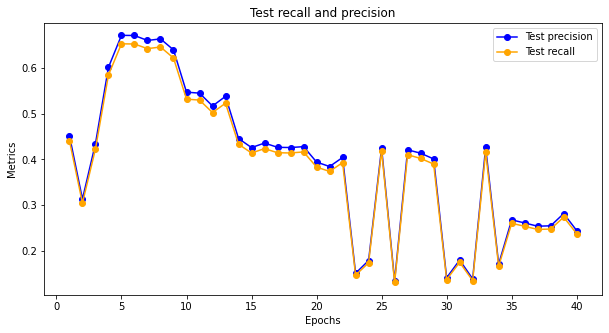

  3%|▎         | 35/1110 [00:00<00:06, 176.36it/s, epoch=1, loss=1.416]

Training MemAE on IDS2017 for 200 epochs
Started training


100%|██████████| 1110/1110 [00:06<00:00, 179.34it/s, epoch=200, loss=0.006]


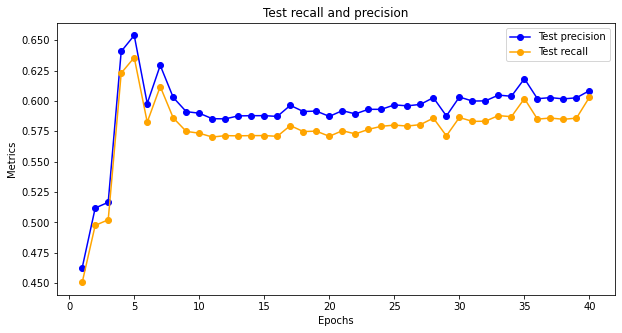

In [22]:
for dataset_name, args in dataset_args.items():
    batch_size, dataset_path, dataset_cls = args["batch_size"], args["dataset_path"], args["cls"]
    dataset = dataset_cls(path=dataset_path)
    train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)

    n_layers = 2 if dataset_name == "Thyroid" else 4

    # DeepSVDD
    dsvdd_model = DeepSVDD(
        in_features=dataset.in_features,
        n_instances=dataset.n_instances,
        device=device,
        n_layers=n_layers,
        compression_factor=compression_factor,
        act_fn=act_fn,
    )
    dsvdd_trainer = DeepSVDDIDSTrainer(
        validation_ldr=test_ldr,
        model=dsvdd_model,
        batch_size=batch_size,
        lr=lr,
        n_epochs=n_epochs,
        device=device,
        ckpt_fname=os.path.join(dsvdd_ckpt, "deepsvdd"),
        run_test_validation=True,
        keep_ckpt=True
    )
    print("Training DeepSVDD on %s for %d epochs" % (dataset_name, n_epochs))
    dsvdd_trainer.train(train_ldr)
    plot_metrics(
        dsvdd_trainer.metric_values["test_precision"],
        dsvdd_trainer.metric_values["test_recall"],
        "deepsvdd/%s_thresh-auto" % dataset_name
    )

    # DAGMM
    print("Training DAGMM on %s for %d epochs" % (dataset_name, n_epochs))
    dagmm_model = DAGMM(
        in_features=dataset.in_features,
        n_instances=dataset.n_instances,
        device=device,
        n_mixtures=n_mixtures,
        latent_dim=latent_dim,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        reg_covar=reg_covar,
        n_layers=n_layers,
        compression_factor=compression_factor,
        ae_act_fn="relu",
        gmm_act_fn="relu"
    )
    dagmm_trainer = DAGMMIDSTrainer(
        validation_ldr=test_ldr,
        device=device,
        model=dagmm_model,
        batch_size=batch_size,
        lr=lr,
        n_epochs=n_epochs,
        ckpt_fname=os.path.join(dagmm_ckpt, "dagmm"),
        run_test_validation=True,
        keep_ckpt=True
    )
    print("Training DAGMM on %s for %d epochs" % (dataset_name, n_epochs))
    dagmm_trainer.train(train_ldr)
    plot_metrics(
        dagmm_trainer.metric_values["test_precision"],
        dagmm_trainer.metric_values["test_recall"],
        "dagmm/%s_thresh-auto" % dataset_name
    )

    # MemAE
    memae_model = MemAutoEncoder(
        in_features=dataset.in_features,
        n_instances=dataset.n_instances,
        device=device,
        mem_dim=mem_dim,
        latent_dim=latent_dim,
        shrink_thres=shrink_thres,
        n_layers=n_layers,
        compression_factor=compression_factor,
        alpha=alpha,
        act_fn="relu",
    )
    memae_trainer = MemAEIDSTrainer(
        validation_ldr=test_ldr,
        device=device,
        model=memae_model,
        batch_size=batch_size,
        lr=lr,
        n_epochs=n_epochs,
        ckpt_fname=os.path.join(memae_ckpt, "memae"),
        run_test_validation=True,
        keep_ckpt=True
    )
    print("Training MemAE on %s for %d epochs" % (dataset_name, n_epochs))
    print(train_ldr)
    memae_trainer.train(train_ldr)
    plot_metrics(
        memae_trainer.metric_values["test_precision"],
        memae_trainer.metric_values["test_recall"],
        "memae/%s_thresh-auto" % dataset_name,
    )